In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm 
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples

In [2]:
class FCM:
    def __init__(self, n_clusters=3, max_iter=300, m=2, error=1e-5, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state
        self.cluster_centers_ = None
        self.u = None
        self.labels_ = None

    def fit(self, X, init_centers=None, normalize=False):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        # 是否归一化
        if normalize:
            self.scaler = StandardScaler()
            X = self.scaler.fit_transform(X)
        else:
            self.scaler = None

        # 是否提供有初始聚类中心
        if init_centers is not None:
            self.cluster_centers_ = init_centers
        else:
            random_idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            self.cluster_centers_ = X[random_idx]

        self.u = np.random.dirichlet(np.ones(self.n_clusters), size=X.shape[0])

        for _ in range(self.max_iter):
            u_old = np.copy(self.u)

            # 更新聚类中心
            self.cluster_centers_ = self._update_centroids(X)

            # 更新隶属度矩阵U
            self.u = self._update_membership(X)

            # 检查收敛性
            if np.linalg.norm(self.u - u_old) < self.error:
                break

        # 获取聚类标签
        self.labels_ = np.argmax(self.u, axis=1)

    def _update_centroids(self, X):
        um = self.u ** self.m
        centroids = np.dot(um.T, X) / np.sum(um.T, axis=1)[:, np.newaxis]
        return centroids

    def _update_membership(self, X):
        power = 2 / (self.m - 1)
        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        u = 1.0 / (distances ** power)
        u = u / np.sum(u, axis=1)[:, np.newaxis]
        return u

    def predict(self, X, normalize=False):
        if self.scaler is not None and normalize:
            X = self.scaler.transform(X)

        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        u = 1.0 / (distances ** (2 / (self.m - 1)))
        u = u / np.sum(u, axis=1)[:, np.newaxis]
        return np.argmax(u, axis=1)

In [3]:
def silhouette_plot(X, cluster_labels): 
    n_clusters = len(np.unique(cluster_labels)) 
    silhouette_avg = silhouette_score(X, cluster_labels) 

    # Compute the silhouette coefficient for each sample 
    sample_silhouette_values = silhouette_samples(X, cluster_labels) 

    y_lower = 10
    plt.figure()
    for i in range(n_clusters): 
        # Get the silhouette coefficients for samples in cluster i and sort them 
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == i] 
        cluster_silhouette_values.sort() 

        # Compute the height of the cluster section 
        cluster_size = len(cluster_silhouette_values) 
        y_upper = y_lower + cluster_size 

        # Plot the coefficients for cluster i using horizontal bars 
        color = cm.nipy_spectral(float(i) / n_clusters) 
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, 
                          facecolor=color, edgecolor=color, alpha=0.7) 

        # Show the cluster numbers at the middle 
        plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i)) 

        # Compute the new y_lower for the next cluster 
        y_lower = y_upper + 10  
    # Draw a vertical line for the average silhouette score 
    plt.axvline(x=silhouette_avg, color='red', linestyle='--') 

    plt.yticks([])  # Clear the yaxis labels / ticks     
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]) 
 
    plt.xlabel('Silhouette coefficient values') 
    plt.ylabel('Cluster label')
    plt.show()

In [4]:
def plot_cluster(X, fcm):
    # 使用PCA进行降维以便绘图
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # 绘制聚类结果
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=fcm.labels_, cmap='viridis', marker='o', edgecolor='k')
    # plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='*')
    plt.title('FCM Clustering of Iris Dataset')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

In [5]:
iris_data = load_iris()
X = iris_data.data
y = iris_data.target

In [6]:
# 定义 k 值的范围
c_values = range(2, 21)

# 存储每个 k 值的评估指标
scores = {
    'adjusted_rand_score': [],
    'adjusted_mutual_info_score': [],
    'completeness_score': [],
    'fowlkes_mallows_score': [],
    'silhouette_score': [],
    'calinski_harabasz_score': []
}

In [7]:
# 对每个 k 值进行聚类并计算评估指标
for c in c_values:
    fcm = FCM(n_clusters=c)
    fcm.fit(X, normalize=True)
    fcm.fit(X, init_centers=fcm.cluster_centers_, normalize=True)
    labels = fcm.labels_
    scores['silhouette_score'].append(silhouette_score(X, labels))
print("Finished")

Finished


In [8]:
# 绘图函数
def plot_metric(metric_name):
    plt.figure(figsize=(12, 8))
    plt.plot(c_values, scores[metric_name])
    plt.xlabel('Number of Clusters (C)')
    plt.ylabel('Score')
    plt.title(f'{metric_name} for Iris Dataset')
    plt.xticks(np.arange(2, 21, 1))
    plt.xlim(2, 21)
    plt.grid(True)
    plt.show()

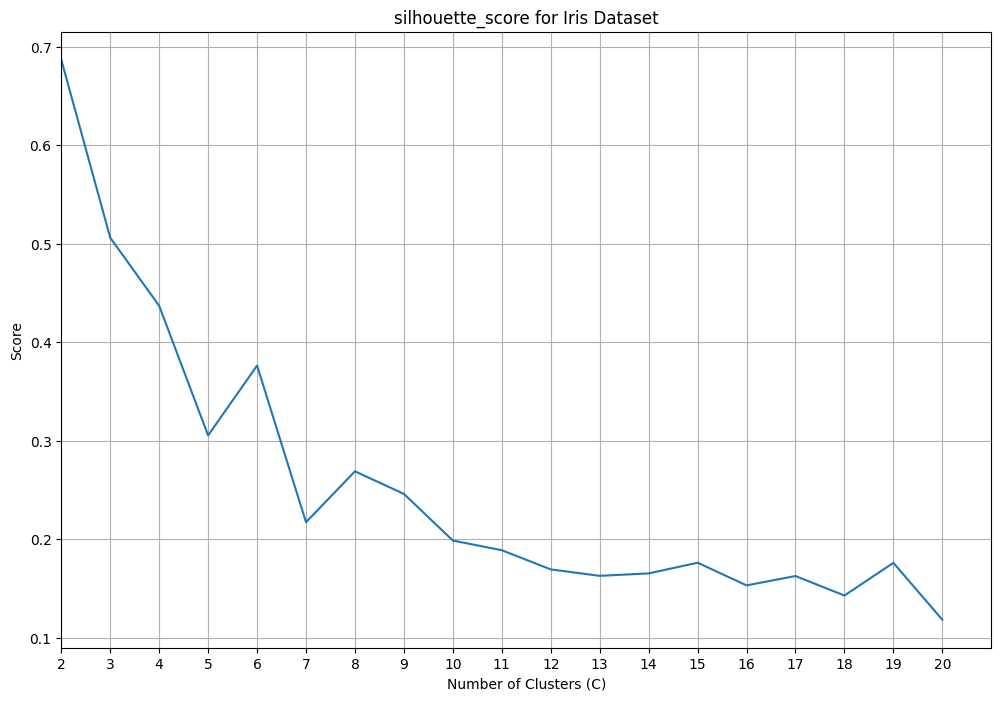

In [9]:
plot_metric('silhouette_score') # 轮廓系数评价法 silhouette_score

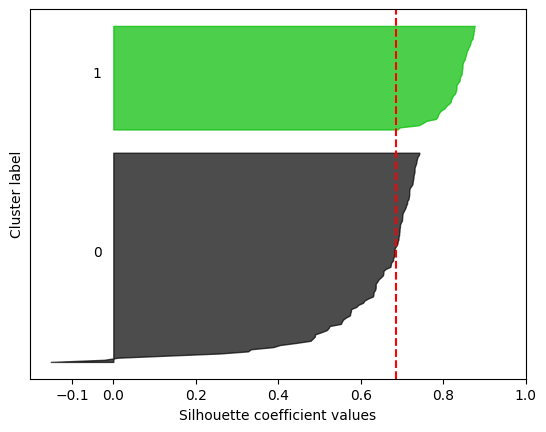

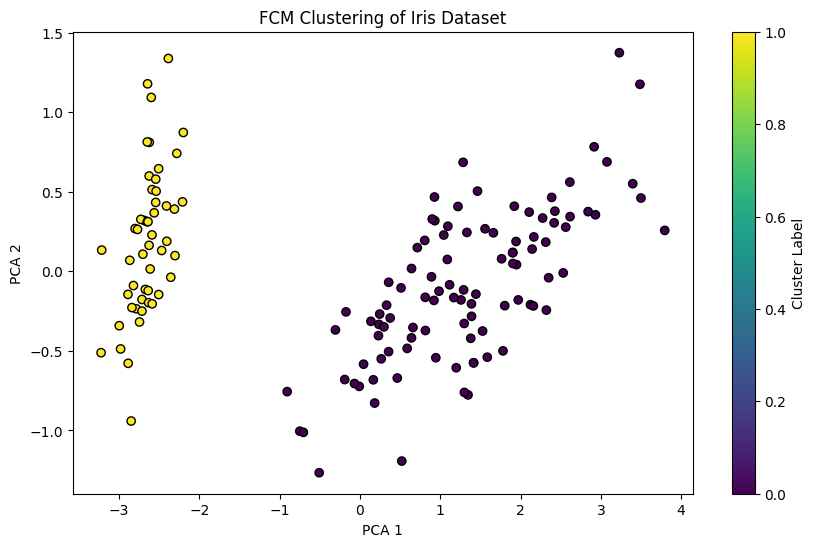

In [10]:
fcm = FCM(n_clusters=2)
fcm.fit(X, normalize=True)
fcm.fit(X, init_centers=fcm.cluster_centers_, normalize=True)
labels = fcm.labels_
silhouette_plot(X, labels)
plot_cluster(X, fcm)

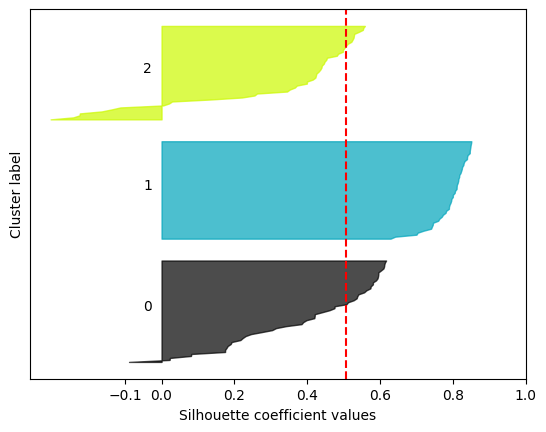

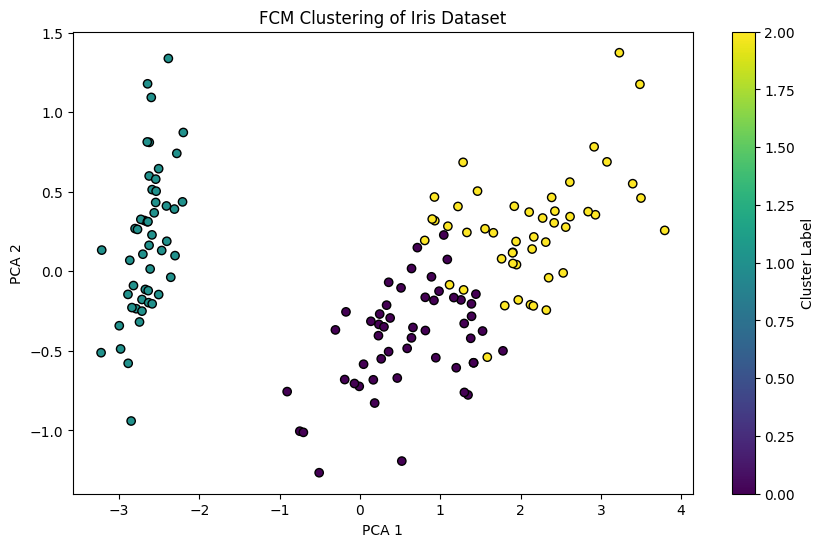

In [11]:
fcm = FCM(n_clusters=3)
fcm.fit(X, normalize=True)
fcm.fit(X, init_centers=fcm.cluster_centers_, normalize=True)
labels = fcm.labels_
silhouette_plot(X, labels)
plot_cluster(X, fcm)